# SDSS Tutorial #2:  The Expanding Universe

[Prof. Britt Lundgren, University of North Carolina Asheville](https://astrophysics.wp.unca.edu/britt-lundgren/)



## Objective
 - Using Sloan Digital Sky Survey (SDSS) data to reproduce one of the most fundamental discoveries of modern cosmology: the distance-velocity relation for galaxies.

## Learning Outcomes

By the end of this notebook, you should be able to: 
 - understand various methods that have historically been used to estimate the distances to galaxies,
 - visualize the galaxy distance-velocity relation using original data published by Edwin Hubble and Milton Humason,
 - reproduce the distance-velocity relation using modern galaxy observations from the SDSS,
 - understand Malmquist bias and its effect on magnitude-limited astronomy surveys, and
 - understand how color, shape, and redshift correlate in the SDSS spectroscopic galaxy sample.
 

## Prerequisites

* This notebook assumes that the user has basic proficiency in the **Python** programming language.
* This notebook uses **SQL queries** to select data from the SDSS database. If the SQL language and/or the SDSS database is new to you, we recommend this [brief tutorial](http://cas.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx). 
* This notebook is intended to be run in the [SciServer Compute](http://www.sciserver.org/tools/compute/) platform. If you have not used SciServer before, please review the [first notebook](https://escip.io/notebooks/sdss_tutorial_1.html) in this series of activities. 


## Introduction

The Belgian Astronomer and Catholic priest Georges Lemaître was one of the earliest theorists to apply Albert Einstein's theory of general relativity to cosmology. In 1927, Lemaître combined galaxy radial velocity measurements collected by American astronomer Vesto Slipher with distance measurements published by Edwin Hubble to derive the linear relation between galaxy velocity and distance, which he interpreted as evidence of an expanding universe. However, his work was published in a Belgian French language journal with limited readership. Two years later, American astronomer Edwin Hubble (with the aid of his observing partner Milton Humason) would publish similar findings, reaching a larger audience, and as a result Hubble has been historically credited with the first observation of this fundamental relation.

Before we dive into Hubble and Humason's original data, let's import the files and libraries we'll need for this lab...

In [2]:
# Import required images for this notebook
import os

if not os.path.exists('img'):
    !mkdir img
    
imgs = ['conselice_2014.jpg', 'HH_1934_fig.png', 'HH_1934_table.png', 'HH_diagram.png', 'HH_Table.png', 'Hubble1929_table.png', 'Hubble1929.jpg', 'malmquist.png']
for i in imgs:
    if not os.path.exists('img/'+i):
        os.system('wget --no-check-certificate --content-disposition https://github.com/brittlundgren/ASTR420/raw/update_2023/img/'+i)
        os.system('mv %s img/' % i)
        
print('images imported')


images imported


In [1]:
# Import Python libraries to work with SciServer (see http://www.sciserver.org/docs/sciscript-python/)

import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive           # read/write to/from SciDrive, cloud-based storage for your work
import numpy as np                  # standard Python library for math operations
import pandas                       # package for structuring and visualizing data
import matplotlib.pyplot as plt     # package for graphing and visualization 
print('SciServer libraries imported')

SciServer libraries imported


In [2]:
# Apply some special settings to the imported libraries

# ensures columns get written completely in notebook
pandas.set_option('display.max_colwidth', -1)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Image, SVG, Math
print('Settings applied')

Settings applied


In [3]:
# So that we're able to make plots, import matplotlib and some of its modules

import matplotlib
%config InlineBackend.rc = {}
from matplotlib import pylab as plt
%matplotlib inline
print('OK')


OK


**NOTE: In order for embedded images to display properly in this notebook, it may be necessary to restart the kernel and reopen this notebook before continuing. Do not re-compile the cell above after restarting.**

# The Distance-Velocity Relation for Galaxies

In 1929, Edwin Hubble published [a paper entitled "A Relation between Distance and Radial Velocity among Extra-Galactic Nebulae"](https://www.pnas.org/content/15/3/168), which used precise distance estimates based on the brightest resolved stars in 24 galaxies in the local universe.  What he showed was a generally linear relationship between distances and the recession velocities of galaxies.


![Distance-Velocity Relation](img/Hubble1929.jpg)

**Above:** Figure 1 from Hubble's 1929 paper: "A Relation between Distance and Radial Velocity among Extra-Galactic Nebulae"

Hubble wrote: _"The results establish a roughly linear relation between velocities and distances among nebulae for which velocities have been previously published, and the relation appears to dominate the distribution of velocities. In order to investigate the matter on a much larger scale, Mr. Humason at Mount Wilson has initiated a program of determining velocities of the most distant nebulae that can be observed with confidence. These, naturally, are the brightest nebulae in clusters of nebulae. The first definite result, v = + 3779 km/s for N. G. C. 7619, is thoroughly consistent with the present conclusions. Corrected for the solar motion, this velocity is +3910 km/s, which, with K = 500, corresponds to a distance of 7.8 × 106 parsecs. Since the apparent magnitude is 11.8, the absolute magnitude at such a distance is −17.65, which is of the right order for the brightest nebulae in a cluster..."_

_"...New data to be expected in the near future may modify the significance of the present investigation or, if confirmatory, will lead to a solution having many times the weight. For this reason it is thought premature to discuss in detail the obvious consequences of the present results. For example, if the solar motion with respect to the clusters represents the rotation of the galactic system, this motion could be subtracted from the results for the nebulae and the remainder would represent the motion of the galactic system with respect to the extra-galactic nebulae. "_



----------------
## Estimating Galaxy Distances

Observing the distance-velocity relation in galaxies requires precise measurements of both the radial velocities (motions toward or away from an observer, along the line of sight) and distances for a sizeable sample of galaxies. The radial velocity of a galaxy can be determined precisely by analyzing its spectrum for a measurable redshift (or blueshift, if a galaxy happens to be moving toward us, instead of receeding away). Distances to galaxies, on the other hand, have been historically more challenging to measure. Astronomers now have a well-developed set of methods, referred to as the [cosmic distance ladder](https://en.wikipedia.org/wiki/Cosmic_distance_ladder), which enable the estimation of the distances to astronomical objects near and far. However, not all of these methods were yet known or well refined when Hubble and Humason published their initial discovery of the distance-velocity relation. The section below explores different proxies for distance that Hubble and Humason used in their early work.

In Hubble's 1929 paper he explained: _"Distances of extra-galactic nebulae depend ultimately upon the application of absolute-luminosity criteria to involved stars whose types can be recognized. These include, among others, Cepheid variables, novae, and blue stars involved in emission nebulosity. Numerical values depend upon the zero point of the period-luminosity relation among Cepheids, the other criteria merely check the order of the distances. This method is restricted to the few nebulae which are well resolved by existing instruments. A study of these nebulae, together with those in which any stars at all can be recognized, indicates the probability of an approximately uniform upper limit to the absolute luminosity of stars, in the late-type spirals and irregular nebulae at least, of the order of M (photographic) = -6.3. The apparent luminosities of the brightest stars in such nebulae are thus criteria which, although rough and to be applied with caution."_

The table below, which was included in the same paper, is described as follows: _"The first seven distances are the most reliable, depending, except for M32 the companion of M31, upon extensive investigations of many stars involved. The next thirteen distances, depending upon the criterion of a uniform upper limit of stellar luminosity, are subject to considerable probable errors but are believed to be the most reasonable values at present available. The last four objects appear to be in the Virgo Cluster. The distance assigned to the cluster, $2\times10^6$ parsecs, is derived from the distribution of nebular luminosities, together with luminosities of stars in some of the later-type spirals, and difers somewhat from the Harvard estimate of ten million light-years."_



![Table](img/Hubble1929_table.png)





Let's explore these original measurements in more detail. The data from Table 1 (above) from Hubble's 1929 paper: "A Relation between Distance and Radial Velocity among Extra-Galactic Nebulae" are digitized in the cell below.

In [6]:
### Data for the nearest galaxies ###

# the most reliable distances to the nearest galaxies, using standard stars 
# the data are reported in units of megaparsecs (Mpc) = 10^6 parsecs
r_Mpc_best = np.array([0.032, 0.034, 0.214, 0.263, 0.275, 0.275])

# recession velocities of the nearest galaxies (km/s)
v_best = np.array([170., 290., -130., -70., -185., -220])

# apparent magnitudes of the nearest galaxies
m_app_best = np.array([1.5, 0.5, 9.0, 7.0, 8.8, 5.0])

# absolute magnitudes of the nearest galaxies
M_abs_best = np.array([-16.0, -17.2, -12.7, -15.1, -13.4, -17.2])



### Data for more distant galaxies ###

# apparent magnitudes of the brightest stars in each galaxy
m_bstar = np.array([17.0, 17.3, 17.3, 17.8, 18.3, 18.5, 18.5, 18.5, 18.5, 18.7, 19.0, 19.0, 19.5, 20.])

# distances determined using standard stars (units of megaparsecs [Mpc])
r_Mpc = np.array([0.45, 0.5, 0.5, 0.63, 0.8, 0.9, 0.9, 0.9, 0.9, 1.0, 1.1, 1.1, 1.4, 1.7])

# recession velocities, determined with spectroscopy
v = np.array([200., 290., 270., 200., 300., -30., 650., 150., 500., 920., 450., 500., 500., 960.])

# estimates of the visual apparent magnitude -- based on available data
m_app = np.array([9.9, 8.4, 7.4, 9.5, 11.3, 8.3, 9.1, 9.0, 10.4, 9.1, 9.6, 10.4, 8.7, 12.0]) 

# total visual absolute magnitude, computed from the apparent magnitude and the distance
M_abs = np.array([-13.3, -15.1, -16.1, -14.5, -13.2, -16.4, -15.7, -15.7, -14.4, -15.9, -15.6, -14.8, -17.0, -14.2])


**In the cell below, use these data to verify the distance modulus equation:**

$m - M = 5\log_{10}(d) - 5$

where "m" is the apparent magnitude, "M" is the absolute magnitude, and "d" is the distance in parsecs.

In [7]:
# your code here

**Now try plotting the distance to each galaxy versus the apparent magnitude of the brightest star in each of those same galaxies:**


In [8]:
# your code here


**Based on your results, can Hubble fairly use the apparent magnitude of the brightest star in each galaxy as a proxy for distance?** Discuss below.

**In the cell below plot the relationship between apparent magnitude and distance using those same data:**

In [9]:
# your code here

**Based on your analysis, is the apparent magnitude of a galaxy a good indicator of its distance?** Discuss below.

**Make a plot to explore the relationship between absolute magnitude and distance:**


In [10]:
# your code here

**Interpret your findings below.**

**In the cell below, use Hubble's data to plot the distance-velocity relation:**

In [11]:
# your code here

**Discuss your findings below.**


## The Relation between Galaxy Redshift and Apparent Magnitude

In 1931 Edwin Hubble and Milton Humason published a paper entitled ["The Velocity-Distance Relation among Extra-Galactic Nebulae"](http://adsabs.harvard.edu/abs/1931ApJ....74...43H), in which they extended their analysis to more distant galaxies and demonstrated more clearly the linear relationship between the velocities and distances of galaxies on large scales.  **For these more distant galaxies, they didn't have precise distance measurements from standard stars, so they used the average galaxies' apparent magnitudes as a proxy for distance.**  

The strong linear relation shown below and now known as the Hubble-Humason (or Hubble-Lemaître) Relation, is clear. The interpretation of this result was that the universe was expanding -- a major paradigm shift in modern cosmology!

![HH_diagram](img/HH_diagram.png)


-------------
# Using SDSS to Verify the Redshift/Velocity-Magnitude Relation 

In the cells below, we will attempt to reproduce this historic result, and in the process explore how redshift correlates with other properties of galaxies in the SDSS database. Let's start by fetching a reasonably large sample of galaxies.  




### Notes on querying the SDSS database:

A very helpful tutorial on how to use SQL to query the SDSS database can be found [here](http://cas.sdss.org/dr15/en/help/howto/search/searchhowtohome.aspx). 

You can view a cookbook of common SDSS SQL searches [here](http://cas.sdss.org/dr15/en/help/docs/realquery.aspx).

A description of the SDSS database structure and the specific information available in different defined Tables and Views, can be found [here](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx).

A simple search below is written to return results from the first 16 galaxies with spectroscopic information in the SDSS "galaxy" table that meet some specific criteria.  

If you don't recognize the names for the data types listed in the "galaxy" table (e.g., "p.ra", "p.g"), you can look them up [here](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=description+Galaxy+V).

**Modify the SQL query below to return the redshifts, redshift errors, apparent magnitudes (in all 5 filters), and petrosian radii ("petror90_r") for a large (>500) sample of galaxies with spectroscopic observations and high signal-to-noise photometric magnitudes (e.g., g/err_g > 10).**

In [9]:
query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r, p.g, p.r, s.z as redshift
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.g<19
"""
gals = CasJobs.executeQuery(query, "dr16")
gals = gals.set_index('objId')
gals


,ra,dec,petror90_r,g,r,redshift
objId,,,,,,
1237645879551066262,348.902530,1.271886,4.714086,18.24496,17.58728,0.032125
1237645879577477252,49.248942,1.272431,4.013907,18.80885,17.70065,0.110611
1237645879577936138,50.234835,1.271945,6.094829,18.34659,17.64557,0.074298
1237645879578460255,51.443695,1.270073,8.120475,17.96541,17.03493,0.121315
1237645879578460271,51.483584,1.272013,5.663464,17.38520,16.81134,0.048765
1237645879579967591,54.928500,1.271888,5.452299,18.53424,17.39800,0.131787
1237645941824356443,40.285690,-0.714957,14.728620,15.75164,15.03100,0.040287
1237645942905438473,57.025337,0.208845,9.603335,16.17125,15.52131,0.025475
1237645942905438495,57.047052,0.084304,8.079607,18.18264,17.59063,0.036167



**In the cells below, try to reproduce Hubble and Humason's Redshift-Magnitude relation, using the SDSS data you just fetched:**

To most closely approximate Hubble's measurement, plot velocity versus the SDSS g-band apparent magnitude, and format the y-axis in log-space using the [plt.semilogy](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.semilogy.html) fuction.



In [16]:
# your code here

## First, convert your array of redshifts (z) to velocities (v), using the equation:
## z ~ v/c  
## where c is the speed of light (300,000 km/s)



You should find that most of the points lie in a particular region of this plot, but there are some interesting outliers.

Are there any objects in the catalog that *might* not be galaxies?  Revise the SQL query in the cell below to isolate any objects that you think might be suspect, and we'll do a quick visual inspection...

**First, let's isolate a small sample (16) of the objects whose redshifts indicate really small velocities (<1000 km/s).** 

Recall: velocity = (redshift) x (speed of light)

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


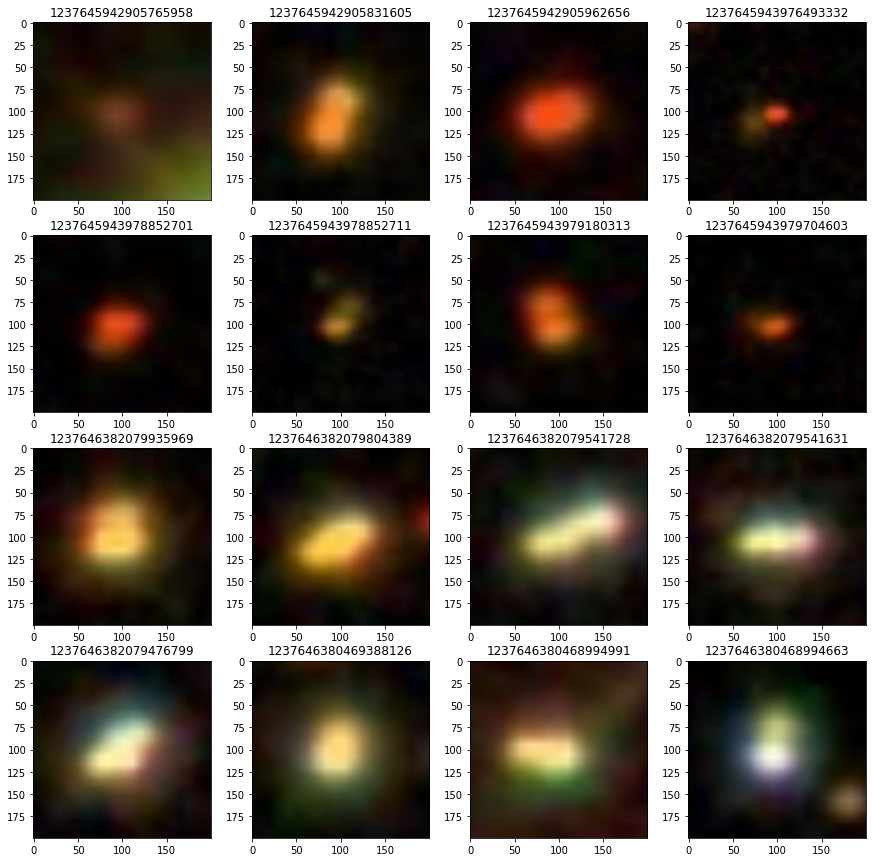

In [10]:
## The query below isolates galaxies with v<1000 km/s

query="""
SELECT TOP 16 p.objId,p.ra,p.dec,p.petror90_r, p.u, p.g, p.r, p.i, p.z, s.z as redshift, s.zErr as redshift_err
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE s.z*300000.0<1000.0
"""
gals_lowv = CasJobs.executeQuery(query, "dr16")
gals_lowv = gals_lowv.set_index('objId')
gals_lowv

#  Below I'm just copying and pasting from our earlier tutorial where we retrieved and plotted a set of SDSS images;
#  No need to worry about the details here, unless you want to change the formatting
#
# set thumbnail parameters
width=200           # image width
height=200          # height
pixelsize=0.396     # image scale
plt.figure(figsize=(15, 15))   # display in a 4x4 grid
subPlotNum = 1

i = 0
nGalaxies = len(gals_lowv)  # I changed the name of my retrieved data to 'gals_lowv', so I've edited this line (and the next) to match
for index,gal in gals_lowv.iterrows():         
    i = i + 1
    if i<17:
        print('Getting image '+str(i)+' of '+str(nGalaxies)+'...')
        if (i == nGalaxies):
            print('Plotting images...')
        scale=2*gal['petror90_r']/pixelsize/width
        img= SciServer.SkyServer.getJpegImgCutout(ra=gal['ra'], dec=gal['dec'], width=width, height=height, scale=scale,dataRelease='DR15')
        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)                               # show images in grid
        plt.title(index)                              # show the object identifier (objId) above the image.

**Do these objects look like normal galaxies?  If not, should they be included in the plot?** Discuss below.


Now let's take a look at the ones that seem to have unusually large velocities.  **Copy the query above and modify it to isolate galaxies with unusually large velocities. Isolate 16 of them with a new query and display their images below.** 

In [2]:
# your code here

**Do you see anything weird in these results?** Discuss below.

**If there are some things you don't think are galaxies, try removing them in a fresh query with reasonable velocity restrictions and redraw the plot of velocity vs. apparent magnitude:**

In [1]:
# your code here

Do you notice a trend or correlation in the data you just plotted? 

**To answer that question quantitatively, let's calculate the best-fit linear regression to this data and add it to the plot...**

The simplest approach is to fit a line, y = mx + c, through these noisy data-points. You can find an example of how to do this [here](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.lstsq.html)

0.19140674577865419 1.026944466907981


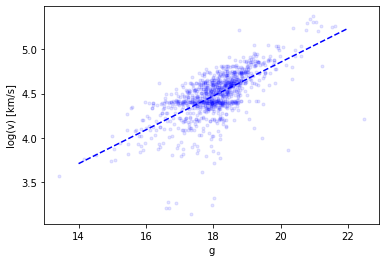

In [29]:
# Modify the example code below to visualize the galaxy data you have queried from the SDSS database.


# make an array with the log of the velocities from the table above
log_v = np.array(np.log10(np.array(velocity)))

# add a best-fit linear trendline
#
A = np.vstack([gals['g'], np.ones(len(gals['g']))]).T  # reformat the data as a matrix
m, c = np.linalg.lstsq(A, log_v, rcond=None)[0] # use numpy's linear algebra library to fit a linear least-squared trendline
print(m, c)

# plot the raw data
plt.clf()
plt.plot(gals['g'], log_v, 'b.', alpha=0.1)

# add this best-fit line to the plot
# 
# make a set of x-values to plug into the equation for the best-fit line
x=np.linspace(14,22,len(velocity))
# plot those x-values versus the y-value from the best-fit equation
plt.plot(x, m*x + c, 'b--', label='Fitted line')

# add some labels and show the plot
plt.ylabel('log(v) [km/s]')
plt.xlabel('g')
plt.show()



Shown below are the measurements of galaxy clusters included in the original paper by Hubble and Humason:
![Hubble-Humason Table](img/HH_Table.png)

**Overlay their points on your plot to see if they agree...**

Try overlaying their best-fit linear trendline as well:

$\log_{10} v = (0.202\pm0.007)m+0.472$

where $v$ is the velocity in km/s, and $m$ is the average apparent magnitude of galaxies in the cluster.

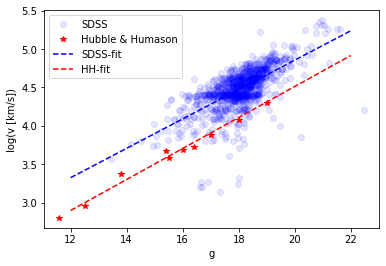

In [31]:

# The table data is digitized below to help get you started...

HH_mag = np.array([12.5, 15.5, 15.4, 16.0, 16.4, 17.0, 18.0, 19.0, 13.8, 11.6])
HH_vel = np.array([890, 3810, 4630, 4820, 5230, 7500, 11800, 19600, 2350, 630])


# take the log of the velocities in the table above
# make an array with the log of the velocities from the table above
HH_vel_log = np.array(np.log10(np.array(HH_vel)))


# plot the data points
plt.plot(gals['g'], log_v, 'bo', alpha=0.1, label='SDSS')
plt.plot(HH_mag, HH_vel_log, 'r*', label='Hubble & Humason')

# add this best-fit line to the plot
x=np.linspace(12,22,len(velocity))
plt.plot(x, m*x + c, 'b--', label='SDSS-fit')
plt.plot(x, 0.202*x + 0.472, 'r--', label='HH-fit')

# Add some labels
plt.ylabel('log(v [km/s])')
plt.xlabel('g')
plt.legend()
plt.show()


The slopes of the best-fit linear trends agree pretty well!  But there is a significant offset in amplitude, which is likely due to a combination of different sample selections and photometric calibrations.  For now we can be satisfied that we are able to reproduce the same fundamental correlation!

--------------------------
## The Potential Pitfalls of Selection Bias

Is it possible that Hubble & Humason's use of cluster galaxies could be introducing some sort of environmental bias?

In 1934, Hubble and Humason [published an update](https://www.pnas.org/content/pnas/20/5/264.full.pdf) to their findings, which used isolated galaxies instead of galaxies in clusters.  The data are provided below:

![table](img/HH_1934_table.png)

The best-fit linear approximation to this velocity-magnitude relation was reported to be: 

$\log_{10} v = 0.2m+0.71$

where $v$ represents velocity in km/s, and $m$ represents apparent magnitude.

**We can try adding this trendline to the previous plot of SDSS data below:**

0.19768394185245514 0.9232046852969403


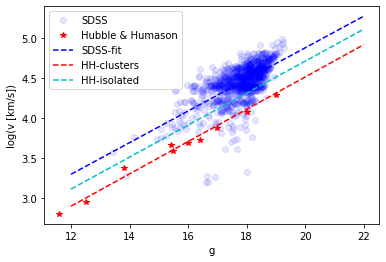

In [77]:
    
A = np.vstack([gals['g'], np.ones(len(gals['g']))]).T
m, c = np.linalg.lstsq(A, log_v, rcond=None)[0]
print(m, c)


# add this best-fit line to the plot
plt.clf()
plt.plot(gals['g'], log_v, 'bo', alpha=0.1, label = 'SDSS')
plt.plot(HH_mag, HH_vel_log, 'r*', label='Hubble & Humason')
x=np.linspace(12,22,len(velocity))
plt.plot(x, m*x + c, 'b--', label='SDSS-fit')
plt.plot(x, 0.202*x + 0.472, 'r--', label='HH-clusters')

# adding Hubble & Humason's trend for isolated galaxies here
plt.plot(x, 0.2*x + 0.71, 'c--', label='HH-isolated') 

plt.ylabel('log(v [km/s])')
plt.xlabel('g')
plt.legend()
plt.show()

We see that Hubble & Humason's isolated galaxy data do agree a little better with the SDSS. _But what is the reason for this shift?_  

Hubble and Humason attributed this result (that isolated galaxies at a particular distance were nearly one magnitude brighter than galaxies in clusters at similar distances) to a bias in their observations, which were apparent-magnitude limited (not absolute-magnitude limited).  A decade earlier, the Swedish astronomer Gunnar Malmquist had demonstrated that in an apparent magnitude-limited survey, one will always be biased toward observing objects with greater than average absolute magnitude. This persistent bias in astronomical data is now referred to as [Malmquist Bias](https://en.wikipedia.org/wiki/Malmquist_bias).

Consider this helpful analogy.  Imagine you are driving toward a city from a great distance surrounded by flat cornfields (e.g., driving to Chicago from Rockford, ~ 60 miles away).  In this thought experiment, ignore any effects due to the curvature of the Earth. At the greatest distances that you can see, only the tallest buildings (e.g., the Sears Tower and other skyscrapers from downtown) will be detectable at the limited resolution of your eye.  Thus, your accounting of objects at that distance will be biased to only the tallest ones, which you can resolve.  Similarly, Malmquist bias works in such a way that at the distant edges of a survey that is limited by some finite apparent magnitude, the objects at the edge of your survey detection limits will be the ones that have the greatest intrinsic brightness (i.e., absolute magnitude) for their distance. 

A figure illustrating this bias effect is shown below ("The Realm of the Nebulae" - Edwin Hubble, 1936, pp.174-175)

![Malmquist](img/malmquist.png)

Hubble and Humason recognized that by applying an apparent magnitude limit when selecting their isolated galaxies, their distant galaxies would be biased, such that they were intrinsically brighter than average for their redshift.

We should expect this bias to also be pervasive in the SDSS!  Later in the course we will have more time to think about ways of correcting for this kind of bias.  But for now, let's investigate a few other observable trends and limitations in the SDSS galaxy data.

------------------------------------
# Understanding the limits of your data

As we spend more time exploring SDSS data and trying to better understand the properties of stars, galaxies, and the universe at large, it's important to know the limits of the dataset and understand various sources of sample selection bias.  

Let's start by exploring the spectroscopic galaxy sample data that you've just fetched.

### 1. The Redshift Distribution

**What is the distribution of redshifts in the sample?**  

This kind of question is best answered by plotting a histogram. In the cell below is some starter code, which sorts the galaxy redshift data in 100 evenly spaced bins, ranging from 0 to 10.  Normal galaxies in the SDSS (ones that aren't extra-luminous due to an active galatic nucleus), typically are limited to z<1.  Any outliers (low-redshift stars, high-redshift AGN) should have been removed by earlier modifications to the query.  If not, make sure you crop them out now.

[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8.18181818  8

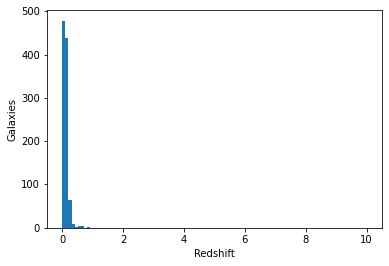

In [33]:
import numpy as np

query="""
SELECT TOP 1000 p.objId,p.ra,p.dec,p.petror90_r, p.u, p.err_u, p.g, p.err_g, p.r, p.err_r, p.i, p.err_i, p.z, p.err_z, s.z as redshift, s.zErr
  FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.u BETWEEN 0 AND 21.5 and 3000000.*s.z>2000 and 3000000.*s.z<3000000
"""
gals = CasJobs.executeQuery(query, "dr16")
gals = gals.set_index('objId')

# modify the limits and spacing of the histogram binning below to better view the galaxy redshift distribution
bins = np.linspace(0,10,100) 
print(bins)

plt.hist(gals['redshift'], bins)
plt.xlabel('Redshift')
plt.ylabel('Galaxies')
plt.show()

The plot above has quite a lot of white space, which makes it hard to see the true shape of the distribution where most of the galaxies lie. So let's resample the data with a different range and bin number:

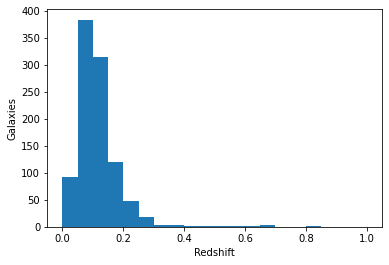

In [34]:
plt.hist(gals['redshift'], range=(0,1), bins=20)
plt.xlabel('Redshift')
plt.ylabel('Galaxies')
plt.show()

By examining the plot above, you can start to get a better understanding of the redshift distribution of the galaxy sample. 

Additionally, it can be helpful to quantify the shape of a sample distribution with some simple statistics. 

**In the cell below calculate the mean and median redshifts for the sample of galaxies:**
(You may find it helpful to refer to these [statistical functions in the NumPy library](https://numpy.org/doc/stable/reference/routines.statistics.html).)



In [19]:
# your code here


### 2. Redshift versus Size

**Make a plot to explore the relationship between galaxy redshift and size, using the data you've just fetched.** 

Be sure to remember to include axis labels, including the correct units of measurement! Remember that the angular size of each galaxy (in units of arcseconds on the sky) is denoted with the 'petror90_r' column in the galaxy table. 

In [20]:
# your code here



**Comment on what you see in the cell below.**  What did you expect before you made this plot?  Do the observations match your expectations?  Why or why not?







### 3. Redshift versus Color

When a galaxy is redshifted its spectroscopic features are shifted to longer (i.e., redder) wavelengths. Does this reddening actually show up in the photometric data (i.e., the characterization of galaxy color index as the difference between two apparent magnitudes)?  

**Pick a pair of SDSS filters and explore graphically how the color changes with redshift.**

In [21]:
# your code here



**In the cell below, comment on what you see, and how you interpret any trends.**

 
 ### 4. Redshift versus Morphology
 
 You may have already thought about the fact that any relation between galaxy color and redshift should be complicated by the fact that galaxies aren't all the same color. In the modern universe, most massive galaxies fall into one of two major populations: blue spirals and red ellipticals.  A changing mix of these types in our survey data with redshift might also affect our measured relation between color and redshift.  In order to explore this possibility, we'll need to get information about the shape (i.e., morphology) of the SDSS galaxies.
 
 The SDSS DR8 includes data on visual galaxy morphologies from the 
 [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) project. Galaxy Zoo is a web-based project
 that used the collective efforts of about 100,000 volunteer 
 citizen scientists to classify more than one million
 SDSS DR7 Main Galaxy Sample (MGS) galaxies.
 Full details on the classification process, including the operation
 of the site and estimates of classification accurary, are given in
 [Lintott et al. (2008)](http://adsabs.harvard.edu/abs/2008MNRAS.389.1179L).

Galaxy Zoo data are contained in tables that begin with "zoo"
in the [Table schema](http://skyserver.sdss.org/dr15/en/help/browser/browser.aspx#&&history=shortdescr+Tables+U). For each galaxy, available data includes its
SDSS object ID and weighted probabilities for each of six different
morphological classifications based on counts of volunteer "votes".
Full details on what data the Galaxy Zoo catalog contains are given
in [Lintott et al. (2010)](http://adsabs.harvard.edu/abs/2011MNRAS.410..166L).

The query below finds the weighted probability (ranging from 0 (very low probability) to 1 (very high probability) that a given galaxy has each of the following six morphological classifications:

elliptical: 'p_el'

spiral (clockwise winding):  'p_cw' 

spiral (counter-clockwise winding): 'p_acw' 

edge-on: 'p_edge'

merger: 'p_mg'

undetermined: 'p_dk'

In [72]:

# This example query finds 100 galaxies that have spectra, clean photometry,
# at least 10 Galaxy Zoo volunteer votes, and at least an 80% probability
# of being clockwise spirals.

query="""
SELECT TOP 100 p.objid, p.ra,p.dec,p.petror90_r, p.g, s.z as z_spec, s.zErr, zns.nvote, zns.p_el as elliptical, zns.p_cw as spiralclock, zns.p_acw as spiralanticlock, zns.p_edge as edgeon, zns.p_dk as dontknow, zns.p_mg as merger
  FROM Galaxy as p
   JOIN ZooNoSpec AS zns ON p.objid = zns.objid
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.clean=1 and zns.nvote >= 10 and zns.p_cw > 0.8
"""
zoo_gals = CasJobs.executeQuery(query, "dr16")
zoo_gals = zoo_gals.set_index('objid')
zoo_gals

,ra,dec,petror90_r,g,z_spec,zErr,nvote,elliptical,spiralclock,spiralanticlock,edgeon,dontknow,merger
objid,,,,,,,,,,,,,
1237668650926342749,241.829163,-0.443972,9.176703,17.61692,0.074706,0.000012,20,0.000,0.850,0.050,0.100,0.000,0.000
1237668650926539340,242.274702,-0.574642,7.471252,17.00881,0.056719,0.000008,32,0.031,0.906,0.000,0.062,0.000,0.000
1237648673458684355,244.496791,-0.498398,9.355639,16.51811,0.050477,0.000009,23,0.000,1.000,0.000,0.000,0.000,0.000
1237655560403354055,248.120390,-0.478861,7.999845,17.13604,0.070390,0.000023,40,0.075,0.800,0.000,0.100,0.000,0.025
1237648704064454738,238.736718,-0.209378,11.107280,15.98897,0.042800,0.000007,37,0.000,0.946,0.054,0.000,0.000,0.000
1237648673995686549,244.875590,-0.038526,12.179800,16.84462,0.079218,0.000027,35,0.000,0.971,0.029,0.000,0.000,0.000
1237655550206804790,247.424991,-0.167082,8.663761,17.66880,0.044132,0.000015,52,0.038,0.808,0.019,0.058,0.019,0.058
1237655554497315264,247.530807,-0.193460,9.905840,16.24303,0.046768,0.000025,31,0.032,0.935,0.000,0.000,0.000,0.032
1237668569320980980,240.498466,0.319765,9.797406,17.93836,0.041010,0.000021,22,0.000,0.818,0.000,0.182,0.000,0.000


**Modify the query above to fetch separate samples of spirals and ellipticals.  Then, overplot the color versus redshift for each sample to compare their distributions.**

In [22]:
# your code here




Shown below is Figure 7 from the 2014 review paper ["The Evolution of Galaxy Structure over Cosmic Time"](https://ui.adsabs.harvard.edu/abs/2014ARA%26A..52..291C/abstract) by Christopher Conselice, which shows the evolution of apparent morphology for massive galxies from three galaxy surveys: the SDSS (York et al. 2000), POWIR (Conselice et al. 2007), and GOODS NICMOS (Buitrago et al. 2008, Conselice et al. 2011b), which together span a large range in redshift. 

![GalEvol](img/conselice_2014.jpg)

**How does this figure compare with the plot you just made?  Are your findings consistent? If not, can you think of a reason for the differences?**

Comment on your findings here, along with your interpretation.